In [1]:
# import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import plotly.express as px

In [2]:
# training dataset

train_df = pd.read_csv('train_classes.csv')
print(train_df)

# filter tags

DEFORESTATION_TAGS = [
    "agriculture",
    "artisinal_mine",
    "conventional_mine",
    "cultivation",
    "road",
    "selective_logging",
    "slash_burn",
]

        image_name                                           tags
0          train_0                                   haze primary
1          train_1                agriculture clear primary water
2          train_2                                  clear primary
3          train_3                                  clear primary
4          train_4      agriculture clear habitation primary road
...            ...                                            ...
40474  train_40474                                  clear primary
40475  train_40475                                         cloudy
40476  train_40476                      agriculture clear primary
40477  train_40477                 agriculture clear primary road
40478  train_40478  agriculture cultivation partly_cloudy primary

[40479 rows x 2 columns]


In [3]:
# testing dataset
# import satellite images of Navi Mumbai taken by LANDSAT 8
# source: https://earthexplorer.usgs.gov/

image_2020 = Image.open("LC08_L1TP_147047_20200507_20200509_01_T1.png")
image_2021 = Image.open("LC08_L1TP_147047_20210510_20210518_01_T1.png")

image_2020.show()
image_2021.show()

# check image sizes; should be almost same

print(image_2020.size)
print(image_2021.size)

(6357, 6490)
(6358, 6492)


In [4]:
# convert images to multidimensional arrays for processing

raw_data_2020 = np.array(image_2020)
raw_data_2021 = np.array(image_2021)

print("2020: {x}".format(x = raw_data_2020[np.ix_([3, 67, 89])]))
print("2021: {x}".format(x = raw_data_2021[np.ix_([3, 67, 89])]))

2020: [[[0 1 6]
  [1 0 5]
  [1 0 3]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[1 0 7]
  [1 0 7]
  [3 2 5]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[1 1 2]
  [1 1 3]
  [2 1 3]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
2021: [[[1 1 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[1 1 3]
  [1 1 3]
  [0 0 2]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


In [5]:
# each pixel has R, G, B values

print("Sample pixel from image: {x}".format(x = image_2020.getpixel((7, 8))))

# separating out the different channels:

b, g, r    = raw_data_2020[:, :, 0], raw_data_2020[:, :, 1], raw_data_2020[:, :, 2]
print("Sample Blue values: {x}".format(x = b[:, 67]))

Sample pixel from image: (136, 131, 104)
Sample Blue values: [123 124 126 ...  29  29  29]


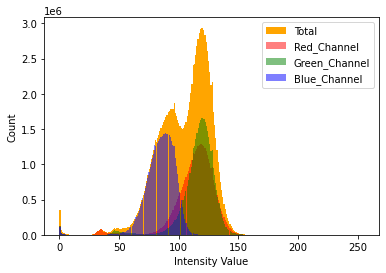

In [6]:
# Distribution of pixels per channel in image_2020

_ = plt.hist(raw_data_2020.ravel(), bins = 256, color = 'orange', )
_ = plt.hist(raw_data_2020[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(raw_data_2020[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
_ = plt.hist(raw_data_2020[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.show()

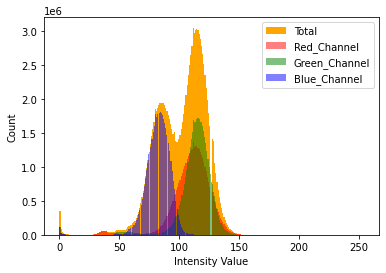

In [7]:
# Distribution of pixels per channel in image_2021

_ = plt.hist(raw_data_2021.ravel(), bins = 256, color = 'orange', )
_ = plt.hist(raw_data_2021[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(raw_data_2021[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
_ = plt.hist(raw_data_2021[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.show()

In [8]:
import cv2  # It is the latest version of OpenCV which is an image and video processing library
import numpy as np  # It is the core library for scientific computing
from sklearn.cluster import KMeans   # KMeans clustering algorithm
from sklearn.decomposition import PCA  # PCA is a technique to emphasise variation and bring out strong patterns in a data set
from collections import Counter   # A Counter is a container that keeps track of how many times equivalent values are added
from scipy.misc import imread, imresize, imsave   # These are the libraries for importing and working on images


def find_vector_set(diff_image, new_size):  
 
    i = 0
    j = 0
    vector_set = np.zeros((int(new_size[0] * new_size[1] / 25), 25))
    while i < vector_set.shape[0]:
        while j < new_size[0]:
            k = 0
            while k < new_size[1]:
                block   = diff_image[j:j+5, k:k+5]
                feature = block.ravel()
                vector_set[i, :] = feature
                k = k + 5
            j = j + 5
        i = i + 1
 
    mean_vec   = np.mean(vector_set, axis = 0)
    vector_set = vector_set - mean_vec
    return vector_set, mean_vec
#In this method, we take non-overlapping blocks of size 5 x 5 from the difference image and flatten them into row vectors.
#If the size of our difference image is m x n, then the number of rows in the vector set would be {m x n}/{5 x 5} .
 

def find_FVS(EVS, diff_image, mean_vec, new):
 
    i = 2                        # Building the feature vector space
                                 #Function find_FVS() determines the feature vector space 
    feature_vector_set = []
 
    while i < new[0] - 2:
        j = 2
        while j < new[1] - 2:
            block = diff_image[i-2:i+3, j-2:j+3]
            feature = block.flatten()
            feature_vector_set.append(feature)
            j = j+1
        i = i+1
 
    FVS = np.dot(feature_vector_set, EVS)
    FVS = FVS - mean_vec
    print("\nfeature vector space size", FVS.shape)
    return FVS
 
#The function find_FVS() is similar to find_vector_set(), but extracts overlapping blocks from the difference image.

def clustering(FVS, components, new):
 
    kmeans = KMeans(components, verbose = 0)
    kmeans.fit(FVS)
    output = kmeans.predict(FVS)
    count  = Counter(output)
 
    least_index = min(count, key = count.get)
    change_map  = np.reshape(output,(new[0] - 4, new[1] - 4))
    return least_index, change_map
# Clustering of the feature vector space, and change map
#the cluster with the lowest number of pixels, and also the highest mean is the cluster belonging to the changed class.

def find_PCAKmeans(imagepath1, imagepath2):
 
    image1 = imread(imagepath1)
    image2 = imread(imagepath2)
# Difference image and the Eigen vector space
# difference image is the pixel-by-pixel subtraction of the 2 images
# difference image, constructed using the multi temporal images
# difference image (i, j) = |image1(i, j) - image2(i, j)|
    new_size = np.asarray(image1.shape) / 5
    new_size = new_size.astype(int) * 5
# The image can be resized to make both the dimensions a multiple of 5 by scipy.misc.imresize()
    image1 = imresize(image1, (new_size)).astype(np.int16)
    image2 = imresize(image2, (new_size)).astype(np.int16)
 
    diff_image = abs(image1 - image2)
    imsave('diff.jpg', diff_image)
 
    vector_set, mean_vec = find_vector_set(diff_image, new_size)
    pca     = PCA()  
    pca.fit(vector_set)
# PCA is applied on vector set to get the Eigen vector space. The Eigen vector space will be a 25 x 25 matrix;
    EVS = pca.components_
 
    FVS     = find_FVS(EVS, diff_image, mean_vec, new_size)  # building the feature vector space
    components = 3
    least_index, change_map = clustering(FVS, components, new_size)

# PCA takes a data set and determines its co-variance matrix after performing mean normalisation on it

    cleanChangeMap = cv2.erode(change_map,kernel)  #  building a change map (a binary image to show the output of change detection)
    imsave("changemap.jpg", change_map)
    imsave("cleanchangemap.jpg", cleanChangeMap)  

ModuleNotFoundError: No module named 'cv2'

In [ ]:
image_2020 = Image.open("LC08_L1TP_147047_20200507_20200509_01_T1.jpg")
image_2021 = Image.open("LC08_L1TP_147047_20210510_20210518_01_T1.jpg")
find_PCAKmeans(a,b)